In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import csv
import scipy.io
import matplotlib.pyplot as plt

D:\Program Files\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load SIFT data
mat_te = scipy.io.loadmat('csvs/desc_te.mat')
mat_tr = scipy.io.loadmat('csvs/desc_tr.mat')

# Access arrays
desc_tr_raw = mat_tr['desc_tr']
desc_te_raw = mat_te['desc_te']

del mat_te
del mat_tr

# Reshape to column
desc_tr = desc_tr_raw.reshape(150)
desc_te = desc_te_raw.reshape(150)

del desc_tr_raw
del desc_te_raw

In [3]:
# Reshape data
data_train_patches  = desc_tr[0].T
class_train_patches = np.asarray([1] * desc_tr[0].T.shape[0]) 
data_test_patches  = desc_te[0].T
class_test_patches = np.asarray([1] * desc_te[0].T.shape[0]) 

# Create column of SIFT patches
for x in range(1,150):
    data_train_patches   = np.concatenate([data_train_patches, desc_tr[x].T])
    class_train_patches  = np.concatenate([class_train_patches, np.asarray([x%10 +1] * desc_tr[x].T.shape[0])])
    data_test_patches   = np.concatenate([data_test_patches, desc_te[x].T])
    class_test_patches  = np.concatenate([class_test_patches, np.asarray([x%10 +1] * desc_te[x].T.shape[0])])

In [4]:
# Shuffle sift patches
data_train_shuf = data_train_patches
data_test_shuf = data_test_patches
class_train_shuf = class_train_patches
class_test_shuf = class_test_patches

del data_train_patches
del data_test_patches
del class_train_patches
del class_test_patches

In [6]:
# Build Model
clf = RandomForestClassifier(n_estimators=10, 
                             max_depth=5, 
                             max_features='auto',
                             bootstrap=True,
                             criterion="entropy",
                             random_state=21,
                             n_jobs=-1)

# Fit Model
clf.fit(data_train_shuf, class_train_shuf)

# Accuracy
predictScore = clf.score(data_test_shuf, class_test_shuf)
print(predictScore)

# Create transformer
rf_enc = OneHotEncoder()
rf_enc.fit(clf.apply(data_train_shuf))

# Transform data
data_train_transf = list([])
data_test_transf = list([])

for i in range(150):
    data_train_transf.append(rf_enc.transform(clf.apply(desc_tr[i].T)).toarray())
    data_test_transf.append(rf_enc.transform(clf.apply(desc_te[i].T)).toarray())
    
# Condense to histograms
data_train = []
data_test = []

for i in range(150):
    data_train_temp = data_train_transf[i][0]
    data_test_temp = data_test_transf[i][0]

    for j in range(1, data_train_transf[i].shape[0]):
        data_train_temp += data_train_transf[i][j]
    data_train.append(data_train_temp)
    for j in range(1, data_test_transf[i].shape[0]):
        data_test_temp += data_test_transf[i][j]
    data_test.append(data_test_temp)


0.089231327304805


<BarContainer object of 320 artists>

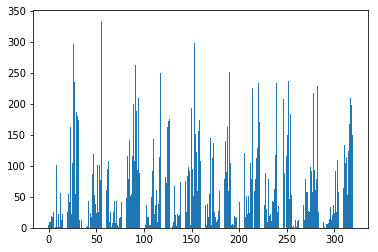

In [7]:
plt.bar(range(320),data_test[110])

<BarContainer object of 320 artists>

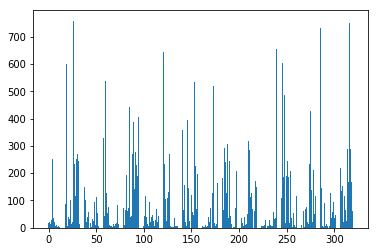

In [8]:
plt.bar(range(320),data_train[110])

In [9]:
# Append class to the raw data
class_train = np.array([])
class_test  = np.array([])
for j in range(10):
    for i in range(15):
        class_test  = np.append(class_test,  j+1)
        class_train = np.append(class_train, j+1)

idx = np.arange(150)

# Shuffle train data
np.random.seed(21)
np.random.shuffle(idx)
data_train_shuf = np.asarray(data_train)[idx]
class_train_shuf = np.asarray(class_train)[idx]

# Shuffle test data
np.random.seed(42)
np.random.shuffle(idx)
data_test_shuf = np.asarray(data_test)[idx]
class_test_shuf = np.asarray(class_test)[idx]

del data_test
del class_test

for numTrees in [1024] :
    for maxDepth in [32] :
        with open('csvs/bigdata4.csv', 'a', newline='') as csvFile:
            writer = csv.writer(csvFile)
            numBins = np.shape(data_train)[1]
            for maxFeatures in range(1, numBins, (numBins//16)) :


                # Build Model
                clf = RandomForestClassifier(n_estimators=numTrees, 
                             max_depth=maxDepth, 
                             max_features=maxFeatures,
                             bootstrap=True,
                             criterion="entropy",
                             random_state=21,
                             n_jobs=-1)

                # Fit Model
                clf.fit(data_train_shuf, class_train_shuf)

                # Accuracy
                predictScore = clf.score(data_test_shuf, class_test_shuf)

                # Classes Predicted
                predictions = clf.predict(data_test_shuf)

                # Probability Of Prediction - confidence
                predict_probs = clf.predict_proba(data_test_shuf)

                packet = [numBins, numTrees, maxDepth, maxFeatures, predictScore]


                writer.writerow(packet)
            csvFile.close()




In [10]:
print(packet)

[320, 1024, 32, 301, 0.56]
